In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from datetime import datetime

# Run if does not have save csv

In [46]:
processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')

processed_data

text  encoded_label
0         [7.1405405e-03 9.9962193e-01 5.4753876e-01 2.6...              1
1         [2.7269310e-01 9.1283846e-01 7.0581239e-01 2.7...              1
2         [3.66024762e-01 5.52640557e-01 1.28829172e-02 ...              1
3         [3.6568302e-01 5.1285905e-01 5.0925948e-02 3.4...              0
4         [3.6568302e-01 5.1285905e-01 5.0925948e-02 3.4...              0
...                                                     ...            ...
16333467  [4.1654095e-01 4.1237536e-01 1.2984258e-04 9.8...              0
16333468  [1.0039466e-01 4.0252590e-01 2.6090756e-02 3.3...              1
16333469  [3.6568302e-01 5.1285905e-01 5.0925948e-02 3.4...              0
16333470  [2.7269310e-01 9.1283846e-01 7.0581239e-01 2.7...              1
16333471  [7.1405405e-03 9.9962193e-01 5.4753876e-01 2.6...              1

[16333472 rows x 2 columns]

In [47]:
processed_data['text'][0]

'[7.1405405e-03 9.9962193e-01 5.4753876e-01 2.6585688e-03 2.7714476e-02\n 7.2706980e-06 3.2682312e-01 5.4654592e-01 7.0690730e-04 2.1562557e-06\n 1.0000000e+00 1.0000000e+00 1.0380623e-01 5.4578459e-01 2.6645912e-03\n 1.5827749e-03 8.7420267e-01 9.2384756e-02 1.0000000e+00 1.2247915e-02\n 3.5753415e-06 1.3228956e-06]'

In [48]:
# split the string column into separate features
def split_string(text):
    # Clean up the string by removing unnecessary characters
    string = text.replace('[', '').replace(']', '').replace('\n', '')

    # Split the string by spaces
    elements = string.split()

    # Convert each element to a float and create a numpy array
    array = np.array([float(element) for element in elements])
    return array 

# processed_data = processed_data['text'].astype(np.float32)
features = processed_data['text'].apply(split_string)
features

0           [0.0071405405, 0.99962193, 0.54753876, 0.00265...
1           [0.2726931, 0.91283846, 0.70581239, 0.00272203...
2           [0.366024762, 0.552640557, 0.0128829172, 0.0, ...
3           [0.36568302, 0.51285905, 0.050925948, 3.422385...
4           [0.36568302, 0.51285905, 0.050925948, 3.422385...
                                  ...                        
16333467    [0.41654095, 0.41237536, 0.00012984258, 9.8240...
16333468    [0.10039466, 0.4025259, 0.026090756, 3.3300845...
16333469    [0.36568302, 0.51285905, 0.050925948, 3.422385...
16333470    [0.2726931, 0.91283846, 0.70581239, 0.00272203...
16333471    [0.0071405405, 0.99962193, 0.54753876, 0.00265...
Name: text, Length: 16333472, dtype: object

In [49]:
processed_data['text'] = features
processed_data

text  encoded_label
0         [0.0071405405, 0.99962193, 0.54753876, 0.00265...              1
1         [0.2726931, 0.91283846, 0.70581239, 0.00272203...              1
2         [0.366024762, 0.552640557, 0.0128829172, 0.0, ...              1
3         [0.36568302, 0.51285905, 0.050925948, 3.422385...              0
4         [0.36568302, 0.51285905, 0.050925948, 3.422385...              0
...                                                     ...            ...
16333467  [0.41654095, 0.41237536, 0.00012984258, 9.8240...              0
16333468  [0.10039466, 0.4025259, 0.026090756, 3.3300845...              1
16333469  [0.36568302, 0.51285905, 0.050925948, 3.422385...              0
16333470  [0.2726931, 0.91283846, 0.70581239, 0.00272203...              1
16333471  [0.0071405405, 0.99962193, 0.54753876, 0.00265...              1

[16333472 rows x 2 columns]

In [50]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
encoded_labels = processed_data["encoded_label"]
processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
processed_data_expanded.dropna(inplace=True)
processed_data_expanded["encoded_labels"] = encoded_labels

processed_data_expanded

feature_0  feature_1  feature_2     feature_3     feature_4  \
0          0.007141   0.999622   0.547539  2.658569e-03  2.771448e-02   
1          0.272693   0.912838   0.705812  2.722036e-03  2.796880e-03   
2          0.366025   0.552641   0.012883  0.000000e+00  3.044642e-03   
3          0.365683   0.512859   0.050926  3.422385e-09  4.322925e-03   
4          0.365683   0.512859   0.050926  3.422385e-09  4.322925e-03   
...             ...        ...        ...           ...           ...   
16333467   0.416541   0.412375   0.000130  9.824007e-11  1.237905e-07   
16333468   0.100395   0.402526   0.026091  3.330084e-10  1.201291e-03   
16333469   0.365683   0.512859   0.050926  3.422385e-09  4.322925e-03   
16333470   0.272693   0.912838   0.705812  2.722036e-03  2.796880e-03   
16333471   0.007141   0.999622   0.547539  2.658569e-03  2.771448e-02   

             feature_5  feature_6  feature_7  feature_8  feature_9  ...  \
0         7.270698e-06   0.326823   0.546546   0.000707   0.000002  ...   
1         2.573098e-09   0.000267   0.705948   0.000125   0.000001  ...   
2         1.097820e-09   0.002235   0.012866   0.002500   0.000021  ...   
3         0.000000e+00   0.000000   0.050936   0.001517   0.000004  ...   
4         0.000000e+00   0.000000   0.050936   0.001517   0.000004  ...   
...                ...        ...        ...        ...        ...  ...   
16333467  0.000000e+00   0.000000   0.000130   0.000013   0.000382  ...   
16333468  1.251528e-08   0.000024   0.026096   0.000625   0.000016  ...   
16333469  0.000000e+00   0.000000   0.050936   0.001517   0.000004  ...   
16333470  2.573098e-09   0.000267   0.705948   0.000125   0.000001  ...   
16333471  7.270698e-06   0.326823   0.546546   0.000707   0.000002  ...   

          feature_13    feature_14    feature_15  feature_16  feature_17  \
0           0.545785  2.664591e-03  1.582775e-03    0.874203    0.092385   
1           0.925553  2.094891e-03  1.927151e-02    0.900780    0.012084   
2           0.925553  2.094891e-03  1.927151e-02    0.900780    0.012084   
3           0.025471  1.957849e-08  5.497347e-05    0.209780    0.002459   
4           0.025402  3.447906e-09  3.262220e-08    0.185330    0.000690   
...              ...           ...           ...         ...         ...   
16333467    0.000363  6.415377e-11  6.534685e-10    0.065911    0.001715   
16333468    0.925553  2.094891e-03  1.927151e-02    0.900780    0.012084   
16333469    0.025402  3.447906e-09  3.262220e-08    0.185330    0.000690   
16333470    0.925553  2.094891e-03  1.927151e-02    0.900780    0.012084   
16333471    0.545785  2.664591e-03  1.582775e-03    0.874203    0.092385   

          feature_18  feature_19    feature_20    feature_21  encoded_labels  
0           1.000000    0.012248  3.575342e-06  1.322896e-06               1  
1           0.576010    0.004933  5.000482e-05  8.040554e-07               1  
2           0.576010    0.004933  5.000482e-05  8.040554e-07               1  
3           0.071049    0.003982  4.054818e-08  6.805531e-06               0  
4           0.078991    0.004506  4.589774e-08  6.035205e-06               0  
...              ...         ...           ...           ...             ...  
16333467    0.002561    0.000006  8.730128e-10  1.500211e-04               0  
16333468    0.576010    0.004933  5.000482e-05  8.040554e-07               1  
16333469    0.078991    0.004506  4.589774e-08  6.035205e-06               0  
16333470    0.576010    0.004933  5.000482e-05  8.040554e-07               1  
16333471    1.000000    0.012248  3.575342e-06  1.322896e-06               1  

[16333472 rows x 23 columns]

In [51]:
processed_data_expanded.to_csv("./output/scaled_balanced_train_data.csv", index=False)

# Training

# If have a saved csv

In [4]:
processed_data_expanded = pd.read_csv('./output/scaled_train_one_col.csv') # not balanced dataset, scaled_balanced_train_data
processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

processed_data_expanded

feature_0  feature_1  feature_2     feature_3  feature_4  feature_5  \
0          0.631080   0.936851   0.000056  0.000000e+00        0.0        0.0   
1          0.631080   0.936851   0.000056  0.000000e+00        0.0        0.0   
2          0.631080   0.936851   0.000056  0.000000e+00        0.0        0.0   
3          0.631080   0.936851   0.000056  0.000000e+00        0.0        0.0   
4          0.631080   0.936851   0.000056  0.000000e+00        0.0        0.0   
...             ...        ...        ...           ...        ...        ...   
16333467   0.357153   0.998255   0.000551  5.662714e-05        0.0        0.0   
16333468   0.357153   0.998255   0.000551  5.662714e-05        0.0        0.0   
16333469   0.357153   0.998255   0.000551  5.662714e-05        0.0        0.0   
16333470   0.357153   0.998255   0.000551  5.662714e-05        0.0        0.0   
16333471   0.532746   0.518543   0.000000  1.376975e-10        0.0        0.0   

          feature_6     feature_7  feature_8  feature_9  ...  feature_13  \
0           0.00000  5.659281e-05        0.0   0.005494  ...    0.015726   
1           0.00000  5.659281e-05        0.0   0.005494  ...    0.015726   
2           0.00000  5.659281e-05        0.0   0.005494  ...    0.015726   
3           0.00000  5.659281e-05        0.0   0.005494  ...    0.015726   
4           0.00000  5.659281e-05        0.0   0.005494  ...    0.015726   
...             ...           ...        ...        ...  ...         ...   
16333467    0.06345  0.000000e+00        0.0   0.001159  ...    0.015726   
16333468    0.06345  0.000000e+00        0.0   0.001159  ...    0.015726   
16333469    0.06345  0.000000e+00        0.0   0.001159  ...    0.015726   
16333470    0.06345  0.000000e+00        0.0   0.001159  ...    0.015726   
16333471    0.00000  2.111672e-07        0.0   0.000000  ...    0.007063   

          feature_14  feature_15  feature_16  feature_17  feature_18  \
0           0.000108    0.035452    0.860028    0.014425    0.009102   
1           0.000108    0.035452    0.860028    0.014425    0.009102   
2           0.000108    0.035452    0.860028    0.014425    0.009102   
3           0.000108    0.035452    0.860028    0.014425    0.009102   
4           0.000108    0.035452    0.860028    0.014425    0.009102   
...              ...         ...         ...         ...         ...   
16333467    0.000108    0.035452    0.860028    0.014425    0.009102   
16333468    0.000108    0.035452    0.860028    0.014425    0.009102   
16333469    0.000108    0.035452    0.860028    0.014425    0.009102   
16333470    0.000108    0.035452    0.860028    0.014425    0.009102   
16333471    0.000018    0.003958    0.646350    0.017016    0.007763   

          feature_19    feature_20  feature_21  encoded_labels  
0           0.000008  0.000000e+00    0.000045               1  
1           0.000008  0.000000e+00    0.000045               1  
2           0.000008  0.000000e+00    0.000045               1  
3           0.000008  0.000000e+00    0.000045               1  
4           0.000008  0.000000e+00    0.000045               1  
...              ...           ...         ...             ...  
16333467    0.000008  0.000000e+00    0.000045               1  
16333468    0.000008  0.000000e+00    0.000045               1  
16333469    0.000008  0.000000e+00    0.000045               1  
16333470    0.000008  0.000000e+00    0.000045               1  
16333471    0.000025  2.061344e-10    0.000076               1  

[16333472 rows x 23 columns]

In [52]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X = processed_data_expanded.drop('encoded_labels', axis=1)
y = processed_data_expanded['encoded_labels']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train

feature_0  feature_1  feature_2     feature_3  feature_4  \
15896907   0.309425   0.390695   0.000179  0.000000e+00   0.000000   
8049081    0.365683   0.512859   0.050926  3.422385e-09   0.004323   
15393905   0.365683   0.512859   0.050926  3.422385e-09   0.004323   
15539025   0.409683   0.384279   0.008975  3.833549e-08   0.000059   
14569267   0.007141   0.999622   0.547539  2.658569e-03   0.027714   
...             ...        ...        ...           ...        ...   
6550634    0.365683   0.512859   0.050926  3.422385e-09   0.004323   
16094478   0.304659   0.915275   1.000000  1.015950e-06   0.428682   
6423388    0.365683   0.512859   0.050926  3.422385e-09   0.004323   
15351219   0.272693   0.912838   0.705812  2.722036e-03   0.002797   
14802022   0.631411   1.000000   0.025717  6.884876e-09   0.000290   

             feature_5  feature_6  feature_7  feature_8     feature_9  ...  \
15896907  0.000000e+00   0.000000   0.000179   0.000000  8.489207e-04  ...   
8049081   0.000000e+00   0.000000   0.050936   0.001517  4.332292e-06  ...   
15393905  0.000000e+00   0.000000   0.050936   0.001517  4.332292e-06  ...   
15539025  3.240519e-10   0.003085   0.008977   0.000062  2.977173e-06  ...   
14569267  7.270698e-06   0.326823   0.546546   0.000707  2.156256e-06  ...   
...                ...        ...        ...        ...           ...  ...   
6550634   0.000000e+00   0.000000   0.050936   0.001517  4.332292e-06  ...   
16094478  5.523559e-06   0.077783   1.000000   0.187500  7.372486e-07  ...   
6423388   0.000000e+00   0.000000   0.050936   0.001517  4.332292e-06  ...   
15351219  2.573098e-09   0.000267   0.705948   0.000125  1.094025e-06  ...   
14802022  0.000000e+00   0.000000   0.025722   0.004285  1.735568e-05  ...   

          feature_12  feature_13    feature_14    feature_15  feature_16  \
15896907    0.570934    0.000748  0.000000e+00  0.000000e+00    0.286322   
8049081     0.453287    0.025471  1.957849e-08  5.497347e-05    0.209780   
15393905    0.453287    0.025471  1.957849e-08  5.497347e-05    0.209780   
15539025    0.678201    0.009153  5.057544e-06  4.661391e-03    0.678597   
14569267    0.103806    0.545785  2.664591e-03  1.582775e-03    0.874203   
...              ...         ...           ...           ...         ...   
6550634     0.685121    0.025402  3.447906e-09  3.262220e-08    0.185330   
16094478    0.089965    1.000000  1.020451e-06  9.418292e-05    0.865698   
6423388     0.453287    0.025471  1.957849e-08  5.497347e-05    0.209780   
15351219    0.349481    0.925553  2.094891e-03  1.927151e-02    0.900780   
14802022    0.923875    0.025870  1.581511e-08  3.922502e-06    0.564139   

          feature_17  feature_18    feature_19    feature_20    feature_21  
15896907    0.000106    0.001373  1.230481e-07  0.000000e+00  3.165269e-04  
8049081     0.002459    0.071049  3.981706e-03  4.054818e-08  6.805531e-06  
15393905    0.002459    0.071049  3.981706e-03  4.054818e-08  6.805531e-06  
15539025    0.082260    0.017892  3.567932e-05  1.566996e-06  6.125149e-05  
14569267    0.092385    1.000000  1.224791e-02  3.575342e-06  1.322896e-06  
...              ...         ...           ...           ...           ...  
6550634     0.000690    0.078991  4.505788e-03  4.589774e-08  6.035205e-06  
16094478    0.021020    0.693429  1.913969e-01  8.025453e-04  7.152744e-07  
6423388     0.002459    0.071049  3.981706e-03  4.054818e-08  6.805531e-06  
15351219    0.012084    0.576010  4.933315e-03  5.000482e-05  8.040554e-07  
14802022    0.000340    0.024872  2.012635e-04  4.346378e-09  1.801349e-05  

[13066777 rows x 22 columns]

In [54]:
print ("X_train_expanded shape: ", X_train.shape)
print ("y_train shape: ", y_train.shape)

print ("----------------------------------")
print("processed_data_expanded has NaN values:", processed_data_expanded.isnull().values.any())
print("X_train has NaN values:", X_train.isnull().values.any())
print("y_train has NaN values:", y_train.isnull().values.any())

print("X_train has infinite values:", np.isinf(X_train.values).any())
print("y_train has infinite values:", np.isinf(y_train.values).any())

print ("----------------------------------")
print("Column dtypes:\n", X_train.dtypes)

X_train_expanded shape:  (13066777, 22)
y_train shape:  (13066777,)
----------------------------------
processed_data_expanded has NaN values: False
X_train has NaN values: False
y_train has NaN values: False
X_train has infinite values: False
y_train has infinite values: False
----------------------------------
Column dtypes:
 feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
feature_20    float64
feature_21    float64
dtype: object


In [56]:
y_train.values

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [11]:
# # Create a simple, small dataset
# X_train_small = X_train_expanded.iloc[:100, :]
# y_train_small = y_train.iloc[:100]

# # Fit the classifier to the small dataset
# clf_small = RandomForestClassifier(n_estimators=100, random_state=42)
# clf_small.fit(X_train_small, y_train_small.values)

In [55]:
y_train.ravel()

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [107]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes= np.unique(y_train), y = y_train.values)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict = {0: 999, 1: 0.01} # 1 : 1 is balanced

class_weight_dict

{0: 999, 1: 0.01}

In [14]:
from sklearn.metrics import roc_auc_score

In [108]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict) # 'balanced' class_weight_dict
clf.fit(X_train, y_train.values)

RandomForestClassifier(class_weight={0: 999, 1: 0.01}, random_state=42)

In [114]:
import pickle

# Assuming clf is your trained model
with open('random_forest_999_0_01.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [16]:
# Predict and evaluate the model
y_test_pred = clf.predict(X_test)
y_test_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on training data
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

Training accuracy: 1.0
Test accuracy: 0.9999993877604123


In [18]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))

Confusion Matrix:
[[  61869       1]
 [      1 3204824]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61870
           1       1.00      1.00      1.00   3204825

    accuracy                           1.00   3266695
   macro avg       1.00      1.00      1.00   3266695
weighted avg       1.00      1.00      1.00   3266695


Accuracy Score:
0.9999993877604123


In [19]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_test_pred)

print(f'Test AUC-ROC: {auc_roc}')

Test AUC-ROC: 0.9999917625241128


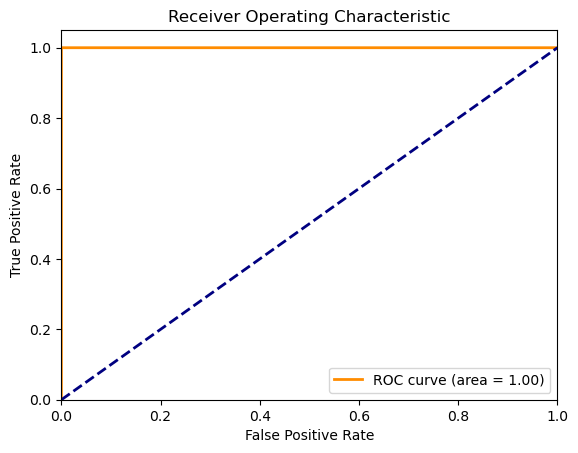

In [20]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Validate with separate data

Uncomment below few cells if run for the first time

In [3]:
# val_df = pd.read_csv('./data/Kaggle/kaggle_validation.csv', index_col=None, header=0)
# val_df

C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\4242665662.py:1: DtypeWarning: Columns (11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv('./data/Kaggle/kaggle_validation.csv', index_col=None, header=0)


hash   nonce  \
0       0x59c83b8c9bbb8d20e42d9a8321c905aade0e6f7c58da...      42   
1       0xc8f6531ae7bedb13017114ca1baa0121e32c40262673...     224   
2       0xa8242ce067278b3951c1b65d14888d9237a2a3ceb49b...      21   
3       0x28c19a64d8de3b1dc7cb2f2ebffdc181b03055bbf277...     339   
4       0xa15635134210c81a1c6ae7d6a8145ebd98a08f438219...       6   
...                                                   ...     ...   
833349  0x6ec2f79d3b0e90f6336330a7766af62aea4e7b6e6e82...  226709   
833350  0xb13e9a2330d276a1dda0d360b545fd177f4cfd403e18...  221093   
833351  0x53dd932f469058be50ca6b37ec30b08499f723e70171...  207792   
833352  0x423bb6e2451bb58c46d095d67cafb8051ca30fb37ecd...       0   
833353  0xbd6c6dae32b0682e078126586f90e7d8083e8729d315...       0   

        transaction_index                                from_address  \
0                      23  0x9da7c19b81e104746aba520904192fe24c98c7f0   
1                      54  0x000000e82ea92a0fa1a6ca1a5064bd2ec749764a   
2                      74  0x4eb0e02d96ff71eca5123d8352b3872a3e5cb4ca   
3                      14  0x50f27cdb650879a41fb07038bf2b818845c20e17   
4                      77  0x16ac1997180cf5f0c084af2cf4038f65eba49803   
...                   ...                                         ...   
833349                236  0x4b01721f0244e7c5b5f63c20942850e447f5a5ee   
833350                 35  0x4b01721f0244e7c5b5f63c20942850e447f5a5ee   
833351                155  0x4b01721f0244e7c5b5f63c20942850e447f5a5ee   
833352                181  0x3c7bff90a5ea6f85ac681b66693a62c9c7e6595c   
833353                164  0x91bd72695911ec9e3fe8b9841f718e62c342d563   

                                        to_address value      gas  \
0       0x0000000000004946c0e9f43f4dee607b0ef1fa1c     0    65938   
1       0x0000000000004946c0e9f43f4dee607b0ef1fa1c     0  1341935   
2       0x0000000000004946c0e9f43f4dee607b0ef1fa1c     0    66496   
3       0x0000000000004946c0e9f43f4dee607b0ef1fa1c     0    48764   
4       0x0000000000004946c0e9f43f4dee607b0ef1fa1c     0    65938   
...                                            ...   ...      ...   
833349  0xff18dbc487b4c2e3222d115952babfda8ba52f5f     0   150000   
833350  0xff18dbc487b4c2e3222d115952babfda8ba52f5f     0   150000   
833351  0xff18dbc487b4c2e3222d115952babfda8ba52f5f     0   150000   
833352  0xff18dbc487b4c2e3222d115952babfda8ba52f5f     0   150000   
833353  0xff18dbc487b4c2e3222d115952babfda8ba52f5f     0   150000   

           gas_price                                              input  \
0       331000000000  0x095ea7b3000000000000000000000000715d6aed40d9...   
1       158156152206  0xa0712d68000000000000000000000000000000000000...   
2        92474912363  0x095ea7b3000000000000000000000000111111125434...   
3       243000000000  0x095ea7b30000000000000000000000007a250d5630b4...   
4       242000000000  0x095ea7b3000000000000000000000000715d6aed40d9...   
...              ...                                                ...   
833349   50000000000  0xa9059cbb000000000000000000000000e820ffd81c88...   
833350   95000000000  0xa9059cbb000000000000000000000000f4c788d1a9af...   
833351   20000000000  0xa9059cbb00000000000000000000000041f314ac683e...   
833352   10000000000  0xa9059cbb0000000000000000000000000a73573cf290...   
833353    5000000000  0xa9059cbb0000000000000000000000000a73573cf290...   

        receipt_cumulative_gas_used  ...  receipt_status  \
0                           1960355  ...             1.0   
1                          11241752  ...             1.0   
2                           7251531  ...             1.0   
3                            799192  ...             1.0   
4                           2980573  ...             1.0   
...                             ...  ...             ...   
833349                      7719801  ...             1.0   
833350                      1225427  ...             1.0   
833351                      4169329  ...             1.0   
833352           

In [4]:
# kaggle_balance_transactions = pd.read_csv('./data/Kaggle/kaggle_eth_addresses.csv')
# # initialize an empty list to hold the results
# results = []
# chunksize = 100000

# # iterate over the frame data frame in chunks
# for i in tqdm(range(0, len(val_df), chunksize)):
#     chunk = val_df[i:i+chunksize]

#     # merge the kaggle_balance_transactions data frame with the current chunk
#     merged_df = pd.merge(kaggle_balance_transactions, chunk, left_on=['Address'], right_on=['from_address'], how='left', suffixes=('_kbt', '_frame'))
#     merged_df = pd.merge(merged_df, chunk, left_on=['Address'], right_on=['to_address'], how='left', suffixes=('_kbt', '_frame'))

#     # append the results to the list
#     results.append(merged_df)

# # concatenate the results into a single data frame
# merged_df = pd.concat(results)

# # drop duplicates
# merged_df.drop_duplicates(inplace=True)

# # select the columns you want to keep
# columns_to_keep = ['Account Type', 'Label', 'Tags'] + ['value_frame', 'gas_frame', 'block_timestamp_frame',
#         'receipt_cumulative_gas_used_frame', #'gas_price_frame',
# #            'receipt_gas_used_frame', 'receipt_contract_address_frame',
# #            'receipt_root_frame', 'receipt_status_frame', 
# #            'block_number_frame', 'block_hash_frame', 'max_fee_per_gas_frame',
# #            'max_priority_fee_per_gas_frame', 'transaction_type_frame', 'input_frame',
#        'receipt_effective_gas_price_frame', 'address_frame', 'from_address_frame', 'to_address_frame', 
#        'eth_balance_frame']

# # create a new data frame with only the columns you want to keep
# new_df = merged_df[columns_to_keep]
# # drop rows where Account Type is NaN
# new_df.dropna(subset=['Account Type'], inplace=True)
# new_df = new_df[new_df['Label'] != 'Label']
# new_df

100%|██████████| 9/9 [00:08<00:00,  1.06it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\2085210468.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=['Account Type'], inplace=True)


Account Type  Label               Tags value_frame  gas_frame  \
0      Smart Contract  Legit               DeFi           0   156924.0   
1      Smart Contract  Legit               DeFi           0   125684.0   
2      Smart Contract  Legit               DeFi           0   152667.0   
3      Smart Contract  Legit               DeFi           0   152652.0   
4      Smart Contract  Legit               DeFi           0   156942.0   
...               ...    ...                ...         ...        ...   
56495          Wallet  Legit              Loans         NaN        NaN   
56548  Smart Contract  Legit  Verified Contract           0   150000.0   
56549  Smart Contract  Legit  Verified Contract           0   150000.0   
56550  Smart Contract  Legit  Verified Contract           0   150000.0   
56576  Smart Contract  Legit     Token Contract           0   150000.0   

         block_timestamp_frame  receipt_cumulative_gas_used_frame  \
0      2020-08-01 06:03:54 UTC                          2597357.0   
1      2019-11-10 15:58:44 UTC                           877737.0   
2      2020-09-12 03:06:30 UTC                           823821.0   
3      2020-09-21 13:16:27 UTC                          7329648.0   
4      2020-07-05 08:35:21 UTC                          4840329.0   
...                        ...                                ...   
56495                      NaN                                NaN   
56548  2020-07-15 20:10:01 UTC                         10680275.0   
56549  2020-05-07 19:39:17 UTC                          6870180.0   
56550  2020-06-17 06:29:44 UTC                          4556743.0   
56576  2019-02-03 13:36:06 UTC                          7509643.0   

       receipt_effective_gas_price_frame  \
0                           9.530000e+10   
1                           2.060000e+10   
2                           1.087000e+11   
3                           3.560000e+11   
4                           2.875000e+10   
...                                  ...   
56495                                NaN   
56548                       3.300000e+10   
56549                       1.561929e+10   
56550                       3.606568e+10   
56576                       3.000000e+09   

                                    address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         NaN   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c   
56576  0xe5b826ca2ca02f09c1725e9bd98d9a8874c30532   

                               from_address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         NaN   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56576  0x4d73aaf5352a39022665f4dafde4f16e39188f53   

                                 to_address_frame    eth_balance_frame  
0      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015  
1      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015  
2      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015  
3      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015  
4      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015  
...                                           ... 

In [5]:
# # Preprocessing of each columns
# for column in new_df.columns:
#     if column != 'Label':
#         unique_val = new_df[column].unique()
#         print ("Column: ", column)

#         if new_df[column].dtypes == 'int64':
#             new_df[column] = new_df[column].fillna(0)
#         else:
#             new_df[column] = new_df[column].astype(str)
#             new_df[column] = new_df[column].fillna('unknown')
    

# #Encode categorical columns:
# encoder = LabelEncoder()
# encoder_tags = LabelEncoder()
# categorical_columns = ['Account Type', 'Tags']
# for col in categorical_columns:
#     if col == "Tags":
#         new_df[col] = encoder_tags.fit_transform(new_df[col])
#     else:
#         new_df[col] = encoder.fit_transform(new_df[col])

# # Target Label column encoder
# new_df['encoded_label'] = encoder.fit_transform(new_df['Label'])

# new_df

Column:  Account Type
Column:  Tags
Column:  value_frame
Column:  gas_frame
Column:  block_timestamp_frame
Column:  receipt_cumulative_gas_used_frame
Column:  receipt_effective_gas_price_frame
Column:  address_frame
Column:  from_address_frame
Column:  to_address_frame
Column:  eth_balance_frame


Account Type  Label  Tags value_frame gas_frame  \
0                 0  Legit    77           0  156924.0   
1                 0  Legit    77           0  125684.0   
2                 0  Legit    77           0  152667.0   
3                 0  Legit    77           0  152652.0   
4                 0  Legit    77           0  156942.0   
...             ...    ...   ...         ...       ...   
56495             1  Legit   161         nan       nan   
56548             0  Legit   275           0  150000.0   
56549             0  Legit   275           0  150000.0   
56550             0  Legit   275           0  150000.0   
56576             0  Legit   256           0  150000.0   

         block_timestamp_frame receipt_cumulative_gas_used_frame  \
0      2020-08-01 06:03:54 UTC                         2597357.0   
1      2019-11-10 15:58:44 UTC                          877737.0   
2      2020-09-12 03:06:30 UTC                          823821.0   
3      2020-09-21 13:16:27 UTC                         7329648.0   
4      2020-07-05 08:35:21 UTC                         4840329.0   
...                        ...                               ...   
56495                      nan                               nan   
56548  2020-07-15 20:10:01 UTC                        10680275.0   
56549  2020-05-07 19:39:17 UTC                         6870180.0   
56550  2020-06-17 06:29:44 UTC                         4556743.0   
56576  2019-02-03 13:36:06 UTC                         7509643.0   

      receipt_effective_gas_price_frame  \
0                         95300000000.0   
1                         20600000000.0   
2                        108700000000.0   
3                        356000000000.0   
4                         28749999999.0   
...                                 ...   
56495                               nan   
56548                     33000000000.0   
56549                     15619287473.0   
56550                     36065678155.0   
56576                      3000000000.0   

                                    address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c   
56576  0xe5b826ca2ca02f09c1725e9bd98d9a8874c30532   

                               from_address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56576  0x4d73aaf5352a39022665f4dafde4f16e39188f53   

                                 to_address_frame    eth_balance_frame  \
0      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015   
1      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015   
2      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015   
3      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015   
4      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7  1481377617827687015   
...                                           ...                  ...   
56495                                         nan                  nan   
56548  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c    52918814015061828   
56549  0xc7e43a1c8e118aa2965f5eabe0e

In [6]:
# # add a new column to calculate transaction amount in USD
# eth_usd_price = 1840  # the ETH/USD price at the time of this code
# df = new_df

# # convert value from wei to ETH
# df['value_frame'] = pd.to_numeric(df['value_frame'], errors='coerce') #/ 10**18
# df['eth_balance_frame'] = pd.to_numeric(df['eth_balance_frame'], errors='coerce')
# # df['USD_value'] = df['value_frame'] * eth_usd_price
# df

Account Type  Label  Tags  value_frame gas_frame  \
0                 0  Legit    77          0.0  156924.0   
1                 0  Legit    77          0.0  125684.0   
2                 0  Legit    77          0.0  152667.0   
3                 0  Legit    77          0.0  152652.0   
4                 0  Legit    77          0.0  156942.0   
...             ...    ...   ...          ...       ...   
56495             1  Legit   161          NaN       nan   
56548             0  Legit   275          0.0  150000.0   
56549             0  Legit   275          0.0  150000.0   
56550             0  Legit   275          0.0  150000.0   
56576             0  Legit   256          0.0  150000.0   

         block_timestamp_frame receipt_cumulative_gas_used_frame  \
0      2020-08-01 06:03:54 UTC                         2597357.0   
1      2019-11-10 15:58:44 UTC                          877737.0   
2      2020-09-12 03:06:30 UTC                          823821.0   
3      2020-09-21 13:16:27 UTC                         7329648.0   
4      2020-07-05 08:35:21 UTC                         4840329.0   
...                        ...                               ...   
56495                      nan                               nan   
56548  2020-07-15 20:10:01 UTC                        10680275.0   
56549  2020-05-07 19:39:17 UTC                         6870180.0   
56550  2020-06-17 06:29:44 UTC                         4556743.0   
56576  2019-02-03 13:36:06 UTC                         7509643.0   

      receipt_effective_gas_price_frame  \
0                         95300000000.0   
1                         20600000000.0   
2                        108700000000.0   
3                        356000000000.0   
4                         28749999999.0   
...                                 ...   
56495                               nan   
56548                     33000000000.0   
56549                     15619287473.0   
56550                     36065678155.0   
56576                      3000000000.0   

                                    address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c   
56576  0xe5b826ca2ca02f09c1725e9bd98d9a8874c30532   

                               from_address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56576  0x4d73aaf5352a39022665f4dafde4f16e39188f53   

                                 to_address_frame  eth_balance_frame  \
0      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
1      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
2      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
3      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
4      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
...                                           ...                ...   
56495                                         nan                NaN   
56548  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c       5.291881e+16   
56549  0xc7e43a1c8e118aa2965f5eabe0e718d83

In [7]:
# df['received_value'] = df.apply(lambda row: row['value_frame'] if row['to_address_frame'] == row['address_frame'] else 0, axis=1)
# df['sent_value'] = df.apply(lambda row: row['value_frame'] if row['from_address_frame'] == row['address_frame'] else 0, axis=1)

# # calculate number of withdrawals and deposits
# df['num_withdrawals'] = df.apply(lambda row: 1 if row['from_address_frame'] == row['address_frame'] else 0, axis=1)
# df['num_deposits'] = df.apply(lambda row: 1 if row['to_address_frame'] == row['address_frame'] else 0, axis=1)

# df

Account Type  Label  Tags  value_frame gas_frame  \
0                 0  Legit    77          0.0  156924.0   
1                 0  Legit    77          0.0  125684.0   
2                 0  Legit    77          0.0  152667.0   
3                 0  Legit    77          0.0  152652.0   
4                 0  Legit    77          0.0  156942.0   
...             ...    ...   ...          ...       ...   
56495             1  Legit   161          NaN       nan   
56548             0  Legit   275          0.0  150000.0   
56549             0  Legit   275          0.0  150000.0   
56550             0  Legit   275          0.0  150000.0   
56576             0  Legit   256          0.0  150000.0   

         block_timestamp_frame receipt_cumulative_gas_used_frame  \
0      2020-08-01 06:03:54 UTC                         2597357.0   
1      2019-11-10 15:58:44 UTC                          877737.0   
2      2020-09-12 03:06:30 UTC                          823821.0   
3      2020-09-21 13:16:27 UTC                         7329648.0   
4      2020-07-05 08:35:21 UTC                         4840329.0   
...                        ...                               ...   
56495                      nan                               nan   
56548  2020-07-15 20:10:01 UTC                        10680275.0   
56549  2020-05-07 19:39:17 UTC                         6870180.0   
56550  2020-06-17 06:29:44 UTC                         4556743.0   
56576  2019-02-03 13:36:06 UTC                         7509643.0   

      receipt_effective_gas_price_frame  \
0                         95300000000.0   
1                         20600000000.0   
2                        108700000000.0   
3                        356000000000.0   
4                         28749999999.0   
...                                 ...   
56495                               nan   
56548                     33000000000.0   
56549                     15619287473.0   
56550                     36065678155.0   
56576                      3000000000.0   

                                    address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c   
56576  0xe5b826ca2ca02f09c1725e9bd98d9a8874c30532   

                               from_address_frame  \
0      0x2b5634c42055806a59e9107ed44d43c426e58258   
1      0x2b5634c42055806a59e9107ed44d43c426e58258   
2      0x2b5634c42055806a59e9107ed44d43c426e58258   
3      0x2b5634c42055806a59e9107ed44d43c426e58258   
4      0x2b5634c42055806a59e9107ed44d43c426e58258   
...                                           ...   
56495                                         nan   
56548  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56549  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56550  0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4   
56576  0x4d73aaf5352a39022665f4dafde4f16e39188f53   

                                 to_address_frame  eth_balance_frame  \
0      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
1      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
2      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
3      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
4      0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7       1.481378e+18   
...                                           ...                ...   
56495                                         nan                NaN   
56548  0xc7e43a1c8e118aa2965f5eabe0e718d83db7a63c       5.291881e+16   
56549  0xc7e43a1c8e118aa2965f5eabe0e718d83

In [8]:
# agg_dict = {
#     'block_timestamp_frame': ['min', 'max'], 
#     'receipt_effective_gas_price_frame': ['count'],
#     'from_address_frame': pd.Series.nunique, 
#     'to_address_frame': pd.Series.nunique,
#     'eth_balance_frame': ['last'],
#     'received_value': ['sum'],
#     'sent_value': ['sum'],
#     'num_withdrawals': ['sum'],
#     'num_deposits': ['sum']
# }
# grouped = df.groupby('address_frame').agg(agg_dict)

# grouped

block_timestamp_frame  \
                                                                min   
address_frame                                                         
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2020-05-29 05:44:39 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2019-10-03 08:54:36 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2019-01-16 01:09:03 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2019-01-21 23:58:38 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2019-01-04 07:14:00 UTC   
...                                                             ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a  2019-10-24 15:38:58 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2020-01-16 14:39:08 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89  2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2018-05-24 10:51:22 UTC   
nan                                                             nan   

                                                                     \
                                                                max   
address_frame                                                         
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2023-03-05 14:31:47 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2020-09-06 10:21:51 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2019-12-11 05:25:56 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2023-03-27 14:24:47 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2023-04-30 17:36:11 UTC   
...                                                             ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a  2019-10-24 15:38:58 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2020-04-17 01:40:56 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89  2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2023-05-01 02:27:59 UTC   
nan                                                             nan   

                                           receipt_effective_gas_price_frame  \
                                                                       count   
address_frame                                                                  
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                               266   
0x000000000000541e251335090ac5b47176af4f7e                                54   
0x0000000000013949f288172bd7e36837bddc7211                                11   
0x0000000000075efbee23fe2de1bd0b7690883cc9                                68   
0x0000000000085d4780b73119b644ae5ecd22b376                              2553   
...                                                                      ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a                                 1   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                                 3   
0xffe4ea384e13295bf74a515a36f552313fb25a89                                 1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                              2599   
nan                                                                   207249   

                                           from_address_frame  \
                                                      nunique   
address_frame                                                   
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                196   
0x000000000000541e251335090ac5b47176af4f7e                 13   
0x0000000000013949f288172bd7e36837bddc7211                  3   
0x0000000000075efbee23fe2de1bd0b7690883cc9                  9   
0x0000000000085d4780b73119b644ae5ecd22b376               1223   
...                                                       ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a                  1   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                  2   
0xffe4ea384e13295bf74a515a36f552313fb25a89                  1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                  1   
nan                                                         1   

                        

In [9]:
# # flatten the column names after aggregation
# grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

# grouped

block_timestamp_frame_min  \
address_frame                                                          
0x0000000000004946c0e9f43f4dee607b0ef1fa1c   2020-05-29 05:44:39 UTC   
0x000000000000541e251335090ac5b47176af4f7e   2019-10-03 08:54:36 UTC   
0x0000000000013949f288172bd7e36837bddc7211   2019-01-16 01:09:03 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9   2019-01-21 23:58:38 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376   2019-01-04 07:14:00 UTC   
...                                                              ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a   2019-10-24 15:38:58 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90   2020-01-16 14:39:08 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89   2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   2018-05-24 10:51:22 UTC   
nan                                                              nan   

                                           block_timestamp_frame_max  \
address_frame                                                          
0x0000000000004946c0e9f43f4dee607b0ef1fa1c   2023-03-05 14:31:47 UTC   
0x000000000000541e251335090ac5b47176af4f7e   2020-09-06 10:21:51 UTC   
0x0000000000013949f288172bd7e36837bddc7211   2019-12-11 05:25:56 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9   2023-03-27 14:24:47 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376   2023-04-30 17:36:11 UTC   
...                                                              ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a   2019-10-24 15:38:58 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90   2020-04-17 01:40:56 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89   2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   2023-05-01 02:27:59 UTC   
nan                                                              nan   

                                            receipt_effective_gas_price_frame_count  \
address_frame                                                                         
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                                      266   
0x000000000000541e251335090ac5b47176af4f7e                                       54   
0x0000000000013949f288172bd7e36837bddc7211                                       11   
0x0000000000075efbee23fe2de1bd0b7690883cc9                                       68   
0x0000000000085d4780b73119b644ae5ecd22b376                                     2553   
...                                                                             ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a                                        1   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                                        3   
0xffe4ea384e13295bf74a515a36f552313fb25a89                                        1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                                     2599   
nan                                                                          207249   

                                            from_address_frame_nunique  \
address_frame                                                            
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                         196   
0x000000000000541e251335090ac5b47176af4f7e                          13   
0x0000000000013949f288172bd7e36837bddc7211                           3   
0x0000000000075efbee23fe2de1bd0b7690883cc9                           9   
0x0000000000085d4780b73119b644ae5ecd22b376                        1223   
...                                                                ...   
0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a                           1   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                           2   
0xffe4ea384e13295bf74a515a36f552313fb25a89                           1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                           1   
nan                                                                  1   

                                            to_address_frame_nunique  \
ad

In [10]:
# # calculate highest received USD
# grouped['highest_transaction_value'] = df.groupby('address_frame')['value_frame'].max()

# grouped.describe()

receipt_effective_gas_price_frame_count  from_address_frame_nunique  \
count                             2.620000e+03                 2620.000000   
mean                              6.310758e+03                  126.591603   
std                               1.263293e+05                 2005.688530   
min                               1.000000e+00                    1.000000   
25%                               2.000000e+00                    1.000000   
50%                               7.000000e+00                    5.000000   
75%                               4.225000e+01                   21.000000   
max                               4.460442e+06                89499.000000   

       to_address_frame_nunique  eth_balance_frame_last  received_value_sum  \
count               2620.000000            2.619000e+03        2.620000e+03   
mean                   1.883969            2.611966e+21        8.169282e+23   
std                    9.253560            8.172050e+22        2.319552e+25   
min                    1.000000            0.000000e+00        0.000000e+00   
25%                    1.000000            0.000000e+00        0.000000e+00   
50%                    1.000000            0.000000e+00        0.000000e+00   
75%                    1.000000            0.000000e+00        4.309077e+14   
max                  194.000000            3.631147e+24        9.439407e+26   

       sent_value_sum  num_withdrawals_sum  num_deposits_sum  \
count    2.620000e+03          2620.000000      2.620000e+03   
mean     5.983168e+21           157.461832      6.280606e+03   
std      2.223819e+23          4424.598462      1.262600e+05   
min      0.000000e+00             0.000000      0.000000e+00   
25%      0.000000e+00             0.000000      2.000000e+00   
50%      0.000000e+00             0.000000      7.000000e+00   
75%      0.000000e+00             0.000000      3.900000e+01   
max      1.104000e+25        207249.000000      4.459472e+06   

       highest_transaction_value  
count               2.619000e+03  
mean                4.664253e+20  
std                 1.246788e+22  
min                 0.000000e+00  
25%                 0.000000e+00  
50%                 0.000000e+00  
75%                 3.049486e+15  
max                 6.000000e+23

In [11]:
# from dateutil.parser import parse

# # convert block_timestamp to datetime format
# grouped.dropna(subset=['block_timestamp_frame_min'], inplace=True)
# grouped.dropna(subset=['block_timestamp_frame_max'], inplace=True)
# grouped = grouped.reset_index(drop=False)

# grouped

address_frame block_timestamp_frame_min  \
0     0x0000000000004946c0e9f43f4dee607b0ef1fa1c   2020-05-29 05:44:39 UTC   
1     0x000000000000541e251335090ac5b47176af4f7e   2019-10-03 08:54:36 UTC   
2     0x0000000000013949f288172bd7e36837bddc7211   2019-01-16 01:09:03 UTC   
3     0x0000000000075efbee23fe2de1bd0b7690883cc9   2019-01-21 23:58:38 UTC   
4     0x0000000000085d4780b73119b644ae5ecd22b376   2019-01-04 07:14:00 UTC   
...                                          ...                       ...   
2615  0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a   2019-10-24 15:38:58 UTC   
2616  0xffa9817f20ab5742ad016e094b42716cdd4fcb90   2020-01-16 14:39:08 UTC   
2617  0xffe4ea384e13295bf74a515a36f552313fb25a89   2020-04-28 02:30:26 UTC   
2618  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   2018-05-24 10:51:22 UTC   
2619                                         nan                       nan   

     block_timestamp_frame_max  receipt_effective_gas_price_frame_count  \
0      2023-03-05 14:31:47 UTC                                      266   
1      2020-09-06 10:21:51 UTC                                       54   
2      2019-12-11 05:25:56 UTC                                       11   
3      2023-03-27 14:24:47 UTC                                       68   
4      2023-04-30 17:36:11 UTC                                     2553   
...                        ...                                      ...   
2615   2019-10-24 15:38:58 UTC                                        1   
2616   2020-04-17 01:40:56 UTC                                        3   
2617   2020-04-28 02:30:26 UTC                                        1   
2618   2023-05-01 02:27:59 UTC                                     2599   
2619                       nan                                   207249   

      from_address_frame_nunique  to_address_frame_nunique  \
0                            196                         1   
1                             13                         1   
2                              3                         1   
3                              9                         1   
4                           1223                         1   
...                          ...                       ...   
2615                           1                         1   
2616                           2                         1   
2617                           1                         1   
2618                           1                        16   
2619                           1                         1   

      eth_balance_frame_last  received_value_sum  sent_value_sum  \
0               0.000000e+00        0.000000e+00             0.0   
1               1.016206e+19        7.072622e+18             0.0   
2               0.000000e+00        0.000000e+00             0.0   
3               0.000000e+00        0.000000e+00             0.0   
4               0.000000e+00        0.000000e+00             0.0   
...                      ...                 ...             ...   
2615            0.000000e+00        2.000000e+16             0.0   
2616            0.000000e+00        0.000000e+00             0.0   
2617            0.000000e+00        4.000000e+17             0.0   
2618            2.056215e+20        0.000000e+00             0.0   
2619                     NaN        0.000000e+00             0.0   

      num_withdrawals_sum  num_deposits_sum  highest_transaction_value  
0                       0               266               0.000000e+00  
1                       0                54               5.672622e+18  
2                       0                11               0.000000e+00  
3                       0                68               0.000000e+00  
4                       0              2553               0.000000e+00  
...                   ...               ...                        ...  
2615                    0                 1               2.000000e+16  
2616                    0                 3        

In [12]:
# grouped = grouped.drop(grouped.index[-1])
# grouped['block_timestamp_frame_min'] = grouped['block_timestamp_frame_min'].apply(lambda x: parse(x))
# grouped['block_timestamp_frame_max'] = grouped['block_timestamp_frame_max'].apply(lambda x: parse(x))

# grouped

address_frame block_timestamp_frame_min  \
0     0x0000000000004946c0e9f43f4dee607b0ef1fa1c 2020-05-29 05:44:39+00:00   
1     0x000000000000541e251335090ac5b47176af4f7e 2019-10-03 08:54:36+00:00   
2     0x0000000000013949f288172bd7e36837bddc7211 2019-01-16 01:09:03+00:00   
3     0x0000000000075efbee23fe2de1bd0b7690883cc9 2019-01-21 23:58:38+00:00   
4     0x0000000000085d4780b73119b644ae5ecd22b376 2019-01-04 07:14:00+00:00   
...                                          ...                       ...   
2614  0xff8d1014da6382f4c07461fbd5f3bed733b229f1 2018-01-31 04:18:32+00:00   
2615  0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a 2019-10-24 15:38:58+00:00   
2616  0xffa9817f20ab5742ad016e094b42716cdd4fcb90 2020-01-16 14:39:08+00:00   
2617  0xffe4ea384e13295bf74a515a36f552313fb25a89 2020-04-28 02:30:26+00:00   
2618  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4 2018-05-24 10:51:22+00:00   

     block_timestamp_frame_max  receipt_effective_gas_price_frame_count  \
0    2023-03-05 14:31:47+00:00                                      266   
1    2020-09-06 10:21:51+00:00                                       54   
2    2019-12-11 05:25:56+00:00                                       11   
3    2023-03-27 14:24:47+00:00                                       68   
4    2023-04-30 17:36:11+00:00                                     2553   
...                        ...                                      ...   
2614 2018-08-03 22:08:43+00:00                                        4   
2615 2019-10-24 15:38:58+00:00                                        1   
2616 2020-04-17 01:40:56+00:00                                        3   
2617 2020-04-28 02:30:26+00:00                                        1   
2618 2023-05-01 02:27:59+00:00                                     2599   

      from_address_frame_nunique  to_address_frame_nunique  \
0                            196                         1   
1                             13                         1   
2                              3                         1   
3                              9                         1   
4                           1223                         1   
...                          ...                       ...   
2614                           4                         1   
2615                           1                         1   
2616                           2                         1   
2617                           1                         1   
2618                           1                        16   

      eth_balance_frame_last  received_value_sum  sent_value_sum  \
0               0.000000e+00        0.000000e+00             0.0   
1               1.016206e+19        7.072622e+18             0.0   
2               0.000000e+00        0.000000e+00             0.0   
3               0.000000e+00        0.000000e+00             0.0   
4               0.000000e+00        0.000000e+00             0.0   
...                      ...                 ...             ...   
2614            0.000000e+00        0.000000e+00             0.0   
2615            0.000000e+00        2.000000e+16             0.0   
2616            0.000000e+00        0.000000e+00             0.0   
2617            0.000000e+00        4.000000e+17             0.0   
2618            2.056215e+20        0.000000e+00             0.0   

      num_withdrawals_sum  num_deposits_sum  highest_transaction_value  
0                       0               266               0.000000e+00  
1                       0                54               5.672622e+18  
2                       0                11               0.000000e+00  
3                       0                68               0.000000e+00  
4                       0              2553               0.000000e+00  
...                   ...               ...                        ...  
2614                    0                 4               0.000000e+00  
2615                    0                 1        

In [13]:
# # calculate mean time between transactions
# grouped['mean_time_between_transactions'] = (
#     grouped['block_timestamp_frame_max'] - grouped['block_timestamp_frame_min']) / grouped['receipt_effective_gas_price_frame_count']
# grouped['mean_time_between_transactions'] = grouped['mean_time_between_transactions'].apply(lambda x: x.total_seconds())

# # calculate lifetime of each address
# grouped['lifetime'] = (grouped['block_timestamp_frame_max'] - grouped['block_timestamp_frame_min']).apply(lambda x: x.total_seconds())

# grouped

address_frame block_timestamp_frame_min  \
0     0x0000000000004946c0e9f43f4dee607b0ef1fa1c 2020-05-29 05:44:39+00:00   
1     0x000000000000541e251335090ac5b47176af4f7e 2019-10-03 08:54:36+00:00   
2     0x0000000000013949f288172bd7e36837bddc7211 2019-01-16 01:09:03+00:00   
3     0x0000000000075efbee23fe2de1bd0b7690883cc9 2019-01-21 23:58:38+00:00   
4     0x0000000000085d4780b73119b644ae5ecd22b376 2019-01-04 07:14:00+00:00   
...                                          ...                       ...   
2614  0xff8d1014da6382f4c07461fbd5f3bed733b229f1 2018-01-31 04:18:32+00:00   
2615  0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a 2019-10-24 15:38:58+00:00   
2616  0xffa9817f20ab5742ad016e094b42716cdd4fcb90 2020-01-16 14:39:08+00:00   
2617  0xffe4ea384e13295bf74a515a36f552313fb25a89 2020-04-28 02:30:26+00:00   
2618  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4 2018-05-24 10:51:22+00:00   

     block_timestamp_frame_max  receipt_effective_gas_price_frame_count  \
0    2023-03-05 14:31:47+00:00                                      266   
1    2020-09-06 10:21:51+00:00                                       54   
2    2019-12-11 05:25:56+00:00                                       11   
3    2023-03-27 14:24:47+00:00                                       68   
4    2023-04-30 17:36:11+00:00                                     2553   
...                        ...                                      ...   
2614 2018-08-03 22:08:43+00:00                                        4   
2615 2019-10-24 15:38:58+00:00                                        1   
2616 2020-04-17 01:40:56+00:00                                        3   
2617 2020-04-28 02:30:26+00:00                                        1   
2618 2023-05-01 02:27:59+00:00                                     2599   

      from_address_frame_nunique  to_address_frame_nunique  \
0                            196                         1   
1                             13                         1   
2                              3                         1   
3                              9                         1   
4                           1223                         1   
...                          ...                       ...   
2614                           4                         1   
2615                           1                         1   
2616                           2                         1   
2617                           1                         1   
2618                           1                        16   

      eth_balance_frame_last  received_value_sum  sent_value_sum  \
0               0.000000e+00        0.000000e+00             0.0   
1               1.016206e+19        7.072622e+18             0.0   
2               0.000000e+00        0.000000e+00             0.0   
3               0.000000e+00        0.000000e+00             0.0   
4               0.000000e+00        0.000000e+00             0.0   
...                      ...                 ...             ...   
2614            0.000000e+00        0.000000e+00             0.0   
2615            0.000000e+00        2.000000e+16             0.0   
2616            0.000000e+00        0.000000e+00             0.0   
2617            0.000000e+00        4.000000e+17             0.0   
2618            2.056215e+20        0.000000e+00             0.0   

      num_withdrawals_sum  num_deposits_sum  highest_transaction_value  \
0                       0               266               0.000000e+00   
1                       0                54               5.672622e+18   
2                       0                11               0.000000e+00   
3                       0                68               0.000000e+00   
4                       0              2553               0.000000e+00   
...                   ...               ...                        ...   
2614                    0                 4               0.000000e+00   
2615                    0                 1

In [14]:
# merged_df = grouped.merge(df[['address_frame', 'Account Type', 'Label', 'Tags']], on='address_frame', how='left')
# merged_df

address_frame  \
0         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
1         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
2         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
3         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
4         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
...                                              ...   
16326932  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326933  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326934  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326935  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326936  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   

         block_timestamp_frame_min block_timestamp_frame_max  \
0        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
1        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
2        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
3        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
4        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
...                            ...                       ...   
16326932 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326933 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326934 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326935 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326936 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   

          receipt_effective_gas_price_frame_count  from_address_frame_nunique  \
0                                             266                         196   
1                                             266                         196   
2                                             266                         196   
3                                             266                         196   
4                                             266                         196   
...                                           ...                         ...   
16326932                                     2599                           1   
16326933                                     2599                           1   
16326934                                     2599                           1   
16326935                                     2599                           1   
16326936                                     2599                           1   

          to_address_frame_nunique  eth_balance_frame_last  \
0                                1            0.000000e+00   
1                                1            0.000000e+00   
2                                1            0.000000e+00   
3                                1            0.000000e+00   
4                                1            0.000000e+00   
...                            ...                     ...   
16326932                        16            2.056215e+20   
16326933                        16            2.056215e+20   
16326934                        16            2.056215e+20   
16326935                        16            2.056215e+20   
16326936                        16            2.056215e+20   

          received_value_sum  sent_value_sum  num_withdrawals_sum  \
0                        0.0             0.0                    0   
1                        0.0             0.0                    0   
2                        0.0             0.0                    0   
3                        0.0             0.0                    0   
4                        0.0             0.0                    0   
...                      ...             ...                  ...   
16326932                 0.0             0.0                 2599   
16326933                 0.0             0.0                 2599   
16326934                 0.0             0.0                 2599   
16326935                 0.0             0.0                 2599   
16326936                 0.0             0.0                 2599   

          num_deposits_sum  highest_transaction_va

In [15]:
# from pandas.tseries.offsets import MonthEnd

In [16]:
# # Convert block_timestamp_frame to datetime and calculate the end of month timestamp
# df['block_timestamp_frame'] = pd.to_datetime(df['block_timestamp_frame'])
# df['EndOfMonth'] = df['block_timestamp_frame'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)

# # Group by Tags
# grouped = df.groupby('Tags')

C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\2410443003.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['EndOfMonth'] = df['block_timestamp_frame'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)


In [17]:
# # For each known tag Cluster:
# stats = pd.DataFrame()

# # Mean # of transactions
# stats['MeanNumTransactions'] = grouped['value_frame'].count()

# # Mean balance
# stats['MeanBalance'] = grouped['eth_balance_frame'].mean()

# # Standard Deviation balance
# stats['StdDevBalance'] = grouped['eth_balance_frame'].std()
# stats

MeanNumTransactions   MeanBalance  StdDevBalance
Tags                                                  
0                    1824  0.000000e+00   0.000000e+00
1                    2234  7.745979e+15   1.384365e+17
2                       0           NaN            NaN
3                       0           NaN            NaN
4                       0           NaN            NaN
...                   ...           ...            ...
287                     0           NaN            NaN
288                    30  1.908465e+14   1.045309e+15
289                    27  0.000000e+00   0.000000e+00
290                     4  1.113486e+19   0.000000e+00
291                     0           NaN            NaN

[292 rows x 3 columns]

In [18]:
# # Cluster lifetime (average of nodes)
# stats['ClusterLifetime'] = grouped['block_timestamp_frame'].apply(lambda x: (x.max() - x.min()).days)
# stats

MeanNumTransactions   MeanBalance  StdDevBalance  ClusterLifetime
Tags                                                                   
0                    1824  0.000000e+00   0.000000e+00           1149.0
1                    2234  7.745979e+15   1.384365e+17           1954.0
2                       0           NaN            NaN              NaN
3                       0           NaN            NaN              NaN
4                       0           NaN            NaN              NaN
...                   ...           ...            ...              ...
287                     0           NaN            NaN              NaN
288                    30  1.908465e+14   1.045309e+15            621.0
289                    27  0.000000e+00   0.000000e+00            362.0
290                     4  1.113486e+19   0.000000e+00           1171.0
291                     0           NaN            NaN              NaN

[292 rows x 4 columns]

In [19]:
# # Mean activity:
# ## Number of withdrawals / month
# stats['NumWithdrawalsPerMonth'] = grouped.apply(lambda x: x['num_withdrawals'].sum() / len(x['EndOfMonth'].unique()))

# ## Number of deposits / month
# stats['NumDepositsPerMonth'] = grouped.apply(lambda x: x['num_deposits'].sum() / len(x['EndOfMonth'].unique()))

# stats

MeanNumTransactions   MeanBalance  StdDevBalance  ClusterLifetime  \
Tags                                                                      
0                    1824  0.000000e+00   0.000000e+00           1149.0   
1                    2234  7.745979e+15   1.384365e+17           1954.0   
2                       0           NaN            NaN              NaN   
3                       0           NaN            NaN              NaN   
4                       0           NaN            NaN              NaN   
...                   ...           ...            ...              ...   
287                     0           NaN            NaN              NaN   
288                    30  1.908465e+14   1.045309e+15            621.0   
289                    27  0.000000e+00   0.000000e+00            362.0   
290                     4  1.113486e+19   0.000000e+00           1171.0   
291                     0           NaN            NaN              NaN   

      NumWithdrawalsPerMonth  NumDepositsPerMonth  
Tags                                               
0                   0.275862            63.172414  
1                   1.019231            42.326923  
2                  24.000000            24.000000  
3                  11.000000            11.000000  
4                   1.000000             1.000000  
...                      ...                  ...  
287                 2.000000             2.000000  
288                 2.818182             5.363636  
289                 0.666667             3.666667  
290                 1.000000             2.333333  
291                 3.000000             3.000000  

[292 rows x 6 columns]

In [20]:
# # Mean transaction data/ lifetime:
# ## Mean of received ETH / cluster lifetime
# stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)

# ## Mean of sent ETH / cluster lifetime
# stats['MeanSentETHPerLifetime'] = grouped.apply(lambda x: x['sent_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)

# ## Mean time between transactions
# stats['MeanTimeBetweenTransactions'] = grouped['block_timestamp_frame'].apply(lambda x: x.sort_values().diff().mean().total_seconds()/60)
# stats

C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\483578478.py:3: RuntimeWarning: invalid value encountered in double_scalars
  stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)
C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\483578478.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)
C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\483578478.py:6: RuntimeWarning: invalid value encountered in double_scalars
  stats['MeanSentETHPerLifetime'] = grouped.apply(lambda x: x['sent_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)


MeanNumTransactions   MeanBalance  StdDevBalance  ClusterLifetime  \
Tags                                                                      
0                    1824  0.000000e+00   0.000000e+00           1149.0   
1                    2234  7.745979e+15   1.384365e+17           1954.0   
2                       0           NaN            NaN              NaN   
3                       0           NaN            NaN              NaN   
4                       0           NaN            NaN              NaN   
...                   ...           ...            ...              ...   
287                     0           NaN            NaN              NaN   
288                    30  1.908465e+14   1.045309e+15            621.0   
289                    27  0.000000e+00   0.000000e+00            362.0   
290                     4  1.113486e+19   0.000000e+00           1171.0   
291                     0           NaN            NaN              NaN   

      NumWithdrawalsPerMonth  NumDepositsPerMonth  MeanReceivedETHPerLifetime  \
Tags                                                                            
0                   0.275862            63.172414                1.974682e+15   
1                   1.019231            42.326923                0.000000e+00   
2                  24.000000            24.000000                         NaN   
3                  11.000000            11.000000                         NaN   
4                   1.000000             1.000000                         NaN   
...                      ...                  ...                         ...   
287                 2.000000             2.000000                         NaN   
288                 2.818182             5.363636                1.552572e+17   
289                 0.666667             3.666667                0.000000e+00   
290                 1.000000             2.333333                1.878736e+13   
291                 3.000000             3.000000                         NaN   

      MeanSentETHPerLifetime  MeanTimeBetweenTransactions  
Tags                                                       
0               0.000000e+00                   907.636067  
1               0.000000e+00                  1260.413621  
2                        NaN                          NaN  
3                        NaN                          NaN  
4                        NaN                          NaN  
...                      ...                          ...  
287                      NaN                          NaN  
288             6.360709e+15                 30853.914368  
289             0.000000e+00                 20082.644872  
290             0.000000e+00                562494.783333  
291                      NaN                          NaN  

[292 rows x 9 columns]

In [21]:
# # Reset the index in stats dataframe
# stats_reset = stats.reset_index()

# # Merge stats with merged_df
# final_df = pd.merge(merged_df, stats_reset, left_on='Tags', right_on='Tags', how='left')
# final_df

address_frame  \
0         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
1         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
2         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
3         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
4         0x0000000000004946c0e9f43f4dee607b0ef1fa1c   
...                                              ...   
16326932  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326933  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326934  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326935  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   
16326936  0xffec0067f5a79cff07527f63d83dd5462ccf8ba4   

         block_timestamp_frame_min block_timestamp_frame_max  \
0        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
1        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
2        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
3        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
4        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
...                            ...                       ...   
16326932 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326933 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326934 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326935 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326936 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   

          receipt_effective_gas_price_frame_count  from_address_frame_nunique  \
0                                             266                         196   
1                                             266                         196   
2                                             266                         196   
3                                             266                         196   
4                                             266                         196   
...                                           ...                         ...   
16326932                                     2599                           1   
16326933                                     2599                           1   
16326934                                     2599                           1   
16326935                                     2599                           1   
16326936                                     2599                           1   

          to_address_frame_nunique  eth_balance_frame_last  \
0                                1            0.000000e+00   
1                                1            0.000000e+00   
2                                1            0.000000e+00   
3                                1            0.000000e+00   
4                                1            0.000000e+00   
...                            ...                     ...   
16326932                        16            2.056215e+20   
16326933                        16            2.056215e+20   
16326934                        16            2.056215e+20   
16326935                        16            2.056215e+20   
16326936                        16            2.056215e+20   

          received_value_sum  sent_value_sum  num_withdrawals_sum  ...  Tags  \
0                        0.0             0.0                    0  ...   256   
1                        0.0             0.0                    0  ...   256   
2                        0.0             0.0                    0  ...   256   
3                        0.0             0.0                    0  ...   256   
4                        0.0             0.0                    0  ...   256   
...                      ...             ...                  ...  ...   ...   
16326932                 0.0             0.0                 2599  ...   256   
16326933                 0.0             0.0                 2599  ...   256   
16326934                 0.0             0.0                 2599  ...   256   
16326935                 0.0             0.0                 2599  ...   256   

In [22]:
# # Select only the specific columns from final_df and add 'tag_' prefix to column names
# final_df_selected = final_df[['block_timestamp_frame_min', 'block_timestamp_frame_max', 
#                               'receipt_effective_gas_price_frame_count',
#        'eth_balance_frame_last', 'received_value_sum', 'sent_value_sum',
#        'num_withdrawals_sum', 'num_deposits_sum', 'highest_transaction_value',
#        'mean_time_between_transactions', 'lifetime', 'Account Type', 'Label',
#        'Tags', 'MeanNumTransactions', 'MeanBalance', 'StdDevBalance',
#        'ClusterLifetime', 'NumWithdrawalsPerMonth', 'NumDepositsPerMonth',
#        'MeanReceivedETHPerLifetime', 'MeanSentETHPerLifetime',
#        'MeanTimeBetweenTransactions']]

# final_df_selected

block_timestamp_frame_min block_timestamp_frame_max  \
0        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
1        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
2        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
3        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
4        2020-05-29 05:44:39+00:00 2023-03-05 14:31:47+00:00   
...                            ...                       ...   
16326932 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326933 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326934 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326935 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   
16326936 2018-05-24 10:51:22+00:00 2023-05-01 02:27:59+00:00   

          receipt_effective_gas_price_frame_count  eth_balance_frame_last  \
0                                             266            0.000000e+00   
1                                             266            0.000000e+00   
2                                             266            0.000000e+00   
3                                             266            0.000000e+00   
4                                             266            0.000000e+00   
...                                           ...                     ...   
16326932                                     2599            2.056215e+20   
16326933                                     2599            2.056215e+20   
16326934                                     2599            2.056215e+20   
16326935                                     2599            2.056215e+20   
16326936                                     2599            2.056215e+20   

          received_value_sum  sent_value_sum  num_withdrawals_sum  \
0                        0.0             0.0                    0   
1                        0.0             0.0                    0   
2                        0.0             0.0                    0   
3                        0.0             0.0                    0   
4                        0.0             0.0                    0   
...                      ...             ...                  ...   
16326932                 0.0             0.0                 2599   
16326933                 0.0             0.0                 2599   
16326934                 0.0             0.0                 2599   
16326935                 0.0             0.0                 2599   
16326936                 0.0             0.0                 2599   

          num_deposits_sum  highest_transaction_value  \
0                      266                        0.0   
1                      266                        0.0   
2                      266                        0.0   
3                      266                        0.0   
4                      266                        0.0   
...                    ...                        ...   
16326932                 0                        0.0   
16326933                 0                        0.0   
16326934                 0                        0.0   
16326935                 0                        0.0   
16326936                 0                        0.0   

          mean_time_between_transactions  ...  Tags  MeanNumTransactions  \
0                          328179.052631  ...   256                74766   
1                          328179.052631  ...   256                74766   
2                          328179.052631  ...   256                74766   
3                          328179.052631  ...   256                74766   
4                          328179.052631  ...   256                74766   
...                                  ...  ...   ...                  ...   
16326932                    59926.509041  ...   256                74766   
16326933                    59926.509041  ...   256                74766   
16326934                    59926.509041  ...   256                74766   
16326935                    59926.509041 

In [23]:
# # Replace inf and NaN values with 0 in 'MeanReceivedETHPerLifetime' column
# final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
# final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
# final_df_selected['MeanSentETHPerLifetime'].fillna(0, inplace=True)
# final_df_selected['MeanTimeBetweenTransactions'].fillna(0, inplace=True)
# final_df_selected['StdDevBalance'].fillna(0, inplace=True)

# # Check if there are any NaN values in the entire dataframe
# print(final_df_selected.isnull().any())

C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\1138533592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\1138533592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
C:\Users\vieth\AppData\Local\Temp\ipykernel_29460\1138533592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

block_timestamp_frame_min                  False
block_timestamp_frame_max                  False
receipt_effective_gas_price_frame_count    False
eth_balance_frame_last                     False
received_value_sum                         False
sent_value_sum                             False
num_withdrawals_sum                        False
num_deposits_sum                           False
highest_transaction_value                  False
mean_time_between_transactions             False
lifetime                                   False
Account Type                               False
Label                                      False
Tags                                       False
MeanNumTransactions                        False
MeanBalance                                False
StdDevBalance                              False
ClusterLifetime                            False
NumWithdrawalsPerMonth                     False
NumDepositsPerMonth                        False
MeanReceivedETHPerLi

In [24]:
# final_df_selected.to_csv("./output/validation.csv", index=False)
# del final_df_selected

End of first time cells

In [16]:
# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

In [17]:
# Combine relevant columns into a single text column
with pd.read_csv("./output/validation.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

text  encoded_label
0         2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...              1
1         2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...              1
2         2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...              1
3         2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...              1
4         2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...              1
...                                                     ...            ...
16326932  2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...              1
16326933  2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...              1
16326934  2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...              1
16326935  2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...              1
16326936  2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...              1

[16326937 rows x 2 columns]

In [18]:
from datetime import datetime

# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

features = processed_data['text'].apply(split_string2)
processed_data['text'] = features
processed_data

text  encoded_label
0         [1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...              1
1         [1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...              1
2         [1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...              1
3         [1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...              1
4         [1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...              1
...                                                     ...            ...
16326932  [1527159082.0, 1682908079.0, 2599.0, 2.0562149...              1
16326933  [1527159082.0, 1682908079.0, 2599.0, 2.0562149...              1
16326934  [1527159082.0, 1682908079.0, 2599.0, 2.0562149...              1
16326935  [1527159082.0, 1682908079.0, 2599.0, 2.0562149...              1
16326936  [1527159082.0, 1682908079.0, 2599.0, 2.0562149...              1

[16326937 rows x 2 columns]

In [19]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
processed_data = new_df

In [20]:
processed_data

text  encoded_label
0         [0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....              1
1         [0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....              1
2         [0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....              1
3         [0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....              1
4         [0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....              1
...                                                     ...            ...
16326932  [0.36666092, 0.99976754, 0.0005824536, 5.66271...              1
16326933  [0.36666092, 0.99976754, 0.0005824536, 5.66271...              1
16326934  [0.36666092, 0.99976754, 0.0005824536, 5.66271...              1
16326935  [0.36666092, 0.99976754, 0.0005824536, 5.66271...              1
16326936  [0.36666092, 0.99976754, 0.0005824536, 5.66271...              1

[16326937 rows x 2 columns]

In [21]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
encoded_labels = processed_data["encoded_label"]
processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
processed_data_expanded.dropna(inplace=True)
processed_data_expanded["encoded_labels"] = encoded_labels

processed_data_expanded

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
1          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
2          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
3          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
4          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
...             ...        ...        ...        ...        ...        ...   
16326932   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326933   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326934   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326935   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326936   0.366661   0.999768   0.000582   0.000057        0.0        0.0   

          feature_6  feature_7  feature_8  feature_9  ...  feature_13  \
0          0.000000    0.00006        0.0   0.005379  ...    0.016735   
1          0.000000    0.00006        0.0   0.005379  ...    0.016735   
2          0.000000    0.00006        0.0   0.005379  ...    0.016735   
3          0.000000    0.00006        0.0   0.005379  ...    0.016735   
4          0.000000    0.00006        0.0   0.005379  ...    0.016735   
...             ...        ...        ...        ...  ...         ...   
16326932   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326933   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326934   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326935   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326936   0.038446    0.00000        0.0   0.000982  ...    0.016735   

          feature_14  feature_15  feature_16  feature_17  feature_18  \
0           0.000105    0.038365    0.854204    0.009724    0.008763   
1           0.000105    0.038365    0.854204    0.009724    0.008763   
2           0.000105    0.038365    0.854204    0.009724    0.008763   
3           0.000105    0.038365    0.854204    0.009724    0.008763   
4           0.000105    0.038365    0.854204    0.009724    0.008763   
...              ...         ...         ...         ...         ...   
16326932    0.000105    0.038365    0.854204    0.009724    0.008763   
16326933    0.000105    0.038365    0.854204    0.009724    0.008763   
16326934    0.000105    0.038365    0.854204    0.009724    0.008763   
16326935    0.000105    0.038365    0.854204    0.009724    0.008763   
16326936    0.000105    0.038365    0.854204    0.009724    0.008763   

          feature_19    feature_20  feature_21  encoded_labels  
0           0.000004  2.957059e-08    0.000022               1  
1           0.000004  2.957059e-08    0.000022               1  
2           0.000004  2.957059e-08    0.000022               1  
3           0.000004  2.957059e-08    0.000022               1  
4           0.000004  2.957059e-08    0.000022               1  
...              ...           ...         ...             ...  
16326932    0.000004  2.957059e-08    0.000022               1  
16326933    0.000004  2.957059e-08    0.000022               1  
16326934    0.000004  2.957059e-08    0.000022               1  
16326935    0.000004  2.957059e-08    0.000022               1  
16326936    0.000004  2.957059e-08    0.000022               1  

[16326937 rows x 23 columns]

In [25]:
print ("Data label distribution check")
labels_dict = dict()
for row in tqdm(processed_data_expanded.iterrows()):
#     print (row[1]['Label'])
    label_val = row[1]['encoded_labels']
    if label_val not in labels_dict.keys():
        labels_dict[label_val] = 1
    else:
        labels_dict[label_val] += 1
        
print (labels_dict)

Data label distribution check


16326937it [06:08, 44291.76it/s]

{1.0: 16315526, 0.0: 11411}


# If have saved csv

In [21]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
processed_data_expanded = pd.read_csv('./output/scaled_validation_one_col.csv')
processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

processed_data_expanded

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
1          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
2          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
3          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
4          0.631228   0.978240   0.000059   0.000000        0.0        0.0   
...             ...        ...        ...        ...        ...        ...   
16326932   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326933   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326934   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326935   0.366661   0.999768   0.000582   0.000057        0.0        0.0   
16326936   0.366661   0.999768   0.000582   0.000057        0.0        0.0   

          feature_6  feature_7  feature_8  feature_9  ...  feature_13  \
0          0.000000    0.00006        0.0   0.005379  ...    0.016735   
1          0.000000    0.00006        0.0   0.005379  ...    0.016735   
2          0.000000    0.00006        0.0   0.005379  ...    0.016735   
3          0.000000    0.00006        0.0   0.005379  ...    0.016735   
4          0.000000    0.00006        0.0   0.005379  ...    0.016735   
...             ...        ...        ...        ...  ...         ...   
16326932   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326933   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326934   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326935   0.038446    0.00000        0.0   0.000982  ...    0.016735   
16326936   0.038446    0.00000        0.0   0.000982  ...    0.016735   

          feature_14  feature_15  feature_16  feature_17  feature_18  \
0           0.000105    0.038365    0.854204    0.009724    0.008763   
1           0.000105    0.038365    0.854204    0.009724    0.008763   
2           0.000105    0.038365    0.854204    0.009724    0.008763   
3           0.000105    0.038365    0.854204    0.009724    0.008763   
4           0.000105    0.038365    0.854204    0.009724    0.008763   
...              ...         ...         ...         ...         ...   
16326932    0.000105    0.038365    0.854204    0.009724    0.008763   
16326933    0.000105    0.038365    0.854204    0.009724    0.008763   
16326934    0.000105    0.038365    0.854204    0.009724    0.008763   
16326935    0.000105    0.038365    0.854204    0.009724    0.008763   
16326936    0.000105    0.038365    0.854204    0.009724    0.008763   

          feature_19    feature_20  feature_21  encoded_labels  
0           0.000004  2.957059e-08    0.000022               1  
1           0.000004  2.957059e-08    0.000022               1  
2           0.000004  2.957059e-08    0.000022               1  
3           0.000004  2.957059e-08    0.000022               1  
4           0.000004  2.957059e-08    0.000022               1  
...              ...           ...         ...             ...  
16326932    0.000004  2.957059e-08    0.000022               1  
16326933    0.000004  2.957059e-08    0.000022               1  
16326934    0.000004  2.957059e-08    0.000022               1  
16326935    0.000004  2.957059e-08    0.000022               1  
16326936    0.000004  2.957059e-08    0.000022               1  

[16326937 rows x 23 columns]

In [22]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_val = processed_data_expanded.drop('encoded_labels', axis=1)
y_val = processed_data_expanded['encoded_labels']

# If have saved model

In [ ]:
import pickle

with open('random_forest_999_0_01.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
clf = loaded_model

In [109]:
# Predict and evaluate the model
y_val_pred = clf.predict(X_val)
y_val_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [110]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))

Confusion Matrix:
[[    3121     8290]
 [    3353 16312173]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.27      0.35     11411
           1       1.00      1.00      1.00  16315526

    accuracy                           1.00  16326937
   macro avg       0.74      0.64      0.67  16326937
weighted avg       1.00      1.00      1.00  16326937


Accuracy Score:
0.9992868840003486


In [111]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_val, y_val_pred)

print(f'Test AUC-ROC: {auc_roc}')

Test AUC-ROC: 0.6366512544041502


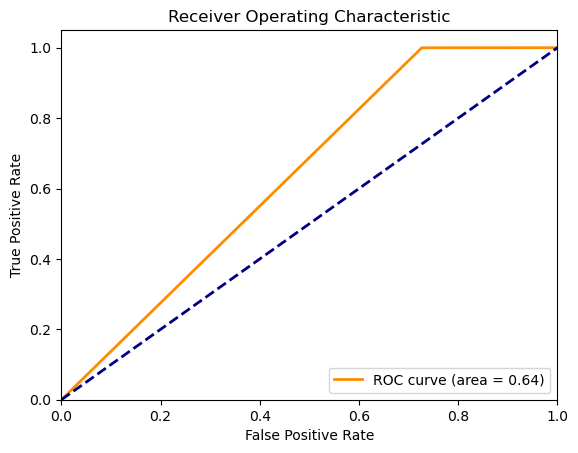

In [113]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


plt.savefig('randomForest_999_0_01.png')
plt.show()